- downscale the temperatures in the era5 land data for the centroid of the era5land cells
- use DEM (alos globe) and era5 land geopotential
- calculate the mean DEM elevation

- calculate the elevation difference (delta elevation)
- calculate the delta temperature per cell
- 

In [108]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os



Text(0.5, 1.0, 'era5land grid')

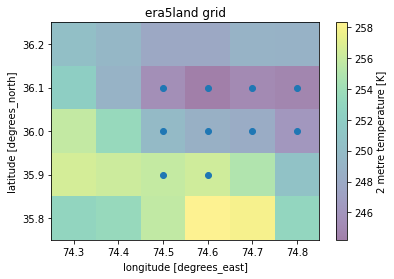

In [109]:
# test era5 land file
# era5land = xr.open_dataset('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/Era5/langtang/temp/2022.nc')
era5land = xr.open_dataset('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/Era5/bagrot/temp/2022.nc')

# csv with coordinates and geopotential (z) 
# langtang_elevation = pd.read_csv('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/elevation/geopotential_langtang.csv')
# elevation = pd.read_csv('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/elevation/geopotential_langtang.csv')
elevation = pd.read_csv('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/elevation/geopotential_bagrot2.csv')

# /Users/varyabazilova/Desktop/uu/0_teaching/Msc_students/Leon/Thesisfiles_Varya/climate/elevation


# plot together to see how points look
era5land.t2m.isel(time = 1).plot(alpha = 0.5)
plt.scatter(x = elevation.Longitude, y = elevation.Latitude)
plt.title('era5land grid')

In [110]:
# dem 30m
# langtang dem - alluvial fans dem part 9
dempath = '/Users/varyabazilova/Desktop/alluvial_fans/dem_all/new_points_catchmetns/all_points/1_dem/'

dem_hma = xr.open_dataset(dempath + 'dem_clip.tif')
# clip using the langtang-ish bbox

# lon = x 
min_lon = era5land.longitude.values.min() - 0.05
max_lon = era5land.longitude.values.max() + 0.05

# lat = y
min_lat = era5land.latitude.values.min() - 0.05
max_lat = era5land.latitude.values.max() + 0.05

dem = dem_hma.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)


Text(0.5, 1.0, 'era5 land and dem together')

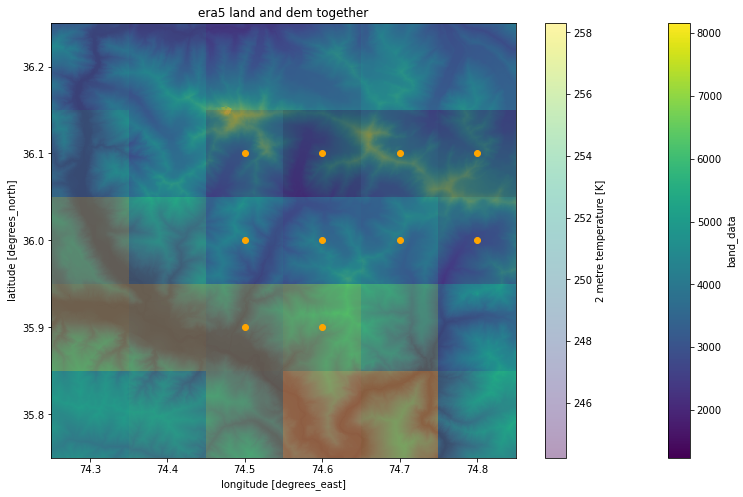

In [111]:
# plot dem together with points 
plt.figure(figsize = (13, 8))


dem.band_data.plot()
era5land.t2m.isel(time = 1).plot(alpha = 0.4)
plt.scatter(x = elevation.Longitude, y = elevation.Latitude, color = 'orange')

plt.title('era5 land and dem together')

## calculate the mean dem value per era5land pixel - xr.coarsen()

In [5]:
# resample the dem file to a lower resolution 
# for xarray coarsen you need a length of coordinates/grid for a new file
# dem

In [112]:
lat_len = len(era5land.latitude.values) # y
lon_len = len(era5land.longitude.values) # x 

y_len = len(dem.y.values)
x_len = len(dem.x.values)

coarsened_dem = dem.coarsen(x=int(x_len/lon_len), y=int(y_len/lat_len), boundary='trim').median()

Text(0.5, 1.0, 'coarsened dem + era5 grid -> do they match?')

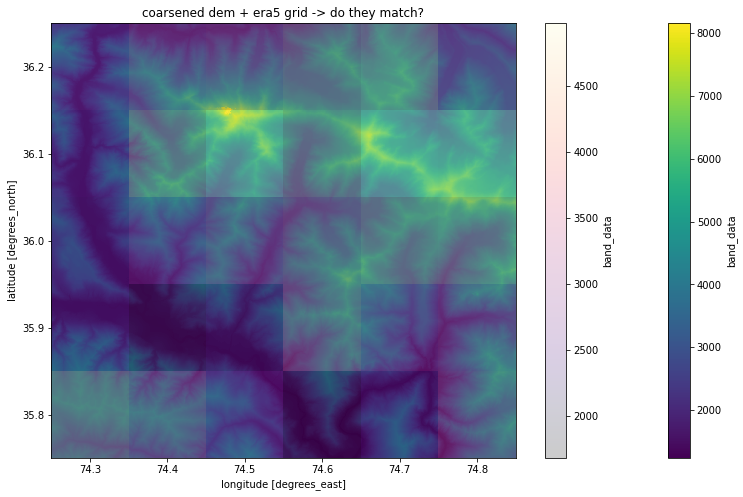

In [115]:
# plot all together to see of the grid matches

plt.figure(figsize = (13, 8))
dem.band_data.plot()
# era5land.t2m.isel(time = 1).plot(alpha = 0.3)
coarsened_dem.band_data.plot(cmap = 'magma', alpha = 0.2)
plt.title('coarsened dem + era5 grid -> do they match?')

## select values for the coordinates from the coarsen grid 

In [116]:
# langtang elevation - csv with z value for the geopotential 
longitudes = elevation.Longitude
latitudes = elevation.Latitude

selected = coarsened_dem.sel(x = longitudes, y = latitudes, method = 'nearest')

In [117]:
df = selected.to_dataframe()
df = df.reset_index()
df = df.drop_duplicates()
df = df.rename(columns = {'x':'Longitude', 'y':'Latitude'})

# round so that coordinates match
elevation = elevation.round(3)
df = df.round(3)

In [118]:
df

,band,Latitude,Longitude,band_data,spatial_ref
0,1,36.1,74.5,4850.0,0
3,1,36.1,74.6,4236.0,0
6,1,36.1,74.7,4977.0,0
8,1,36.1,74.8,4907.0,0
10,1,36.0,74.5,3428.0,0
13,1,36.0,74.6,3717.0,0
16,1,36.0,74.7,4172.0,0
18,1,36.0,74.8,4282.0,0
20,1,35.9,74.5,2053.0,0
23,1,35.9,74.6,3770.0,0


### adjust temperature according to the elevation difference

In [119]:
# merge together
merged = elevation.merge(df, on = ['Longitude', 'Latitude'])

# z - geopotential 
# band_data = dem data 
# delts H = difference between geopotential and DEM info
merged['delta_H'] = merged.z - merged.band_data 
merged['delta_t'] = merged.delta_H * 6.5/1000

In [120]:
merged

,Unnamed: 0,Longitude,Latitude,time,z,cellnr,band,band_data,spatial_ref,delta_H,delta_t
0,0,74.5,36.1,0,4403.640,21,1,4850.0,0,-446.360,-2.901340
1,1,74.5,36.0,0,3537.794,15,1,3428.0,0,109.794,0.713661
2,2,74.5,35.9,0,2473.949,9,1,2053.0,0,420.949,2.736169
3,3,74.6,36.1,0,4765.937,22,1,4236.0,0,529.937,3.444590
4,4,74.6,36.0,0,3951.921,16,1,3717.0,0,234.921,1.526986
5,5,74.6,35.9,0,2595.944,10,1,3770.0,0,-1174.056,-7.631364
6,6,74.7,36.1,0,4716.770,23,1,4977.0,0,-260.230,-1.691495
7,7,74.7,36.0,0,4190.994,17,1,4172.0,0,18.994,0.123461
8,8,74.8,36.1,0,4703.864,24,1,4907.0,0,-203.136,-1.320384
9,9,74.8,36.0,0,4537.517,18,1,4282.0,0,255.517,1.660860


In [121]:
# final table with cell number and delta temperature 

df = merged[['cellnr', 'delta_t']]
df

,cellnr,delta_t
0,21,-2.901340
1,15,0.713661
2,9,2.736169
3,22,3.444590
4,16,1.526986
5,10,-7.631364
6,23,-1.691495
7,17,0.123461
8,24,-1.320384
9,18,1.660860


### downscale the temperatures for each file as input

In [14]:

# Specify the path to the folder containing climate files
# climate_folder = '/Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate'
climate_folder = '/Users/varyabazilova/Desktop/paper2/downscaling_simple/bagrot_climate'

# Step 1: Read the table data into a DataFrame
table_df = df
# Step 2: Iterate over each row in the DataFrame
for index, row in table_df.iterrows():
    cellnr = int(row['cellnr'])
    delta_t = row['delta_t']


    
    # Step 3: Read and update the corresponding file
    file_path = os.path.join(climate_folder, f'climatecell.{cellnr}.met')
    if os.path.exists(file_path):
        # Read the file into a DataFrame
        file_df = pd.read_csv(file_path)
        
        # Update Ta values
        file_df['Ta'] = file_df['Ta'] + delta_t
        
        # Save the updated DataFrame back to the file
        file_df.to_csv(file_path, index=False)
        print(f'Ta values updated for {file_path}')
    else:
        print(f'File {file_path} not found.')

print('All updates complete.')


Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.12.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.13.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.14.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.19.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.20.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.21.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.22.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/climatecell.23.met
Ta values updated for /Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate/cl

# add bagrot coordinates

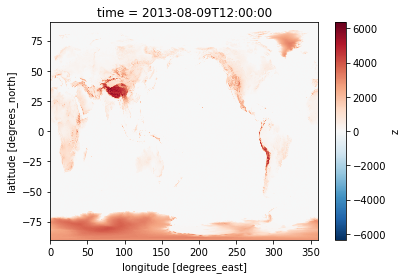

In [47]:
# find geopotential, get the coordinates 

geopotential = xr.open_dataset('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/elevation/geopotential.nc')

geopotential['z'] = geopotential.z /9.80665
geopotential.z.plot()

In [90]:
bagrot_era5land = xr.open_dataset('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/Era5/bagrot/temp/2022.nc')
bagrot_cells = pd.read_csv('/Users/varyabazilova/Desktop/uu/0_teaching/Msc_students/Leon/Thesisfiles_Varya/climate/elevation/geopotential_bagrot.csv')





In [91]:
# bagrot_era5land.t2m.mean(dim = 'time').plot()
# bagrot_era5land.latitude.values
bagrot_cells

,cellnr,z
0,9,2473.948820
1,10,2595.943726
2,15,3537.793567
3,16,3951.920691
4,17,4190.993832
5,18,4537.516726
6,21,4403.639864
7,22,4765.937079
8,23,4716.770366
9,24,4703.864104


In [92]:
geopotential = geopotential.sel(latitude = bagrot_era5land.latitude.values, longitude = bagrot_era5land.longitude.values)
# geopotential = geopotential.drop('time')

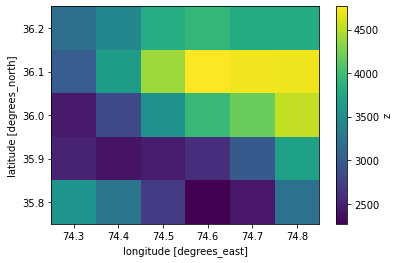

In [93]:
geopotential.z.plot()

In [94]:
geopotentialdf = geopotential.to_dataframe()

In [95]:
geopotentialdf = geopotentialdf.drop_duplicates()
geopotentialdf = geopotentialdf.round(4)

bagrot_cells = bagrot_cells.round(4)

In [96]:
geopotentialdf = geopotentialdf.reset_index()

In [97]:
together = geopotentialdf.merge(bagrot_cells, on = 'z')


In [102]:
geopotentialdf.sort_values('z')
# together.to_csv('/Users/varyabazilova/Desktop/uu/0_teaching/Msc_students/Leon/Thesisfiles_Varya/climate/elevation/geopotential_bagrot2.csv')





In [100]:
together

,longitude,latitude,time,z,cellnr
0,74.500000,36.099998,0,4403.6399,21
1,74.500000,36.000000,0,3537.7936,15
2,74.500000,35.900002,0,2473.9488,9
3,74.599998,36.099998,0,4765.9371,22
4,74.599998,36.000000,0,3951.9207,16
5,74.599998,35.900002,0,2595.9437,10
6,74.699997,36.099998,0,4716.7704,23
7,74.699997,36.000000,0,4190.9938,17
8,74.800003,36.099998,0,4703.8641,24
9,74.800003,36.000000,0,4537.5167,18
